In [360]:
import pandas as pd
import numpy as np

In [361]:
data = pd.read_excel("42M_BTC_VAMS.xlsx", index_col=0, parse_dates=True)
data.head()

,green,yellow,red,signal,BTCUSD
2020-03-01,1,0,0,green,8917.4900
2020-03-02,1,0,0,green,8754.4925
2020-03-03,1,0,0,green,8757.4225
2020-03-04,0,1,0,yellow,9067.5425
2020-03-05,0,0,1,red,9156.3050


In [362]:
data.loc[data.index[data['signal'].isna()], "signal"] = "yellow"

In [363]:
(data["signal"] == "yellow").sum()

np.int64(201)

In [364]:
# data = data["2021-04-01":]
data.head()

,green,yellow,red,signal,BTCUSD
2020-03-01,1,0,0,green,8917.4900
2020-03-02,1,0,0,green,8754.4925
2020-03-03,1,0,0,green,8757.4225
2020-03-04,0,1,0,yellow,9067.5425
2020-03-05,0,0,1,red,9156.3050


In [365]:
import vectorbt as vbt
import numpy as np
import pandas as pd

# Assume your DataFrame is called 'data' and has columns 'BTCUSD' and 'signal'
price = data['BTCUSD']
signal = data['signal']

# Map signals to positions: 1 for green, 0.5 for yellow, 0 for red
signal_map = {'green': 1.0, 'yellow': 0.5, 'red': 0.0}
positions = signal.map(signal_map).fillna(1.0)

# For vectorbt, you need boolean entries/exits
entries1 = (positions.diff().fillna(0) > 0).shift(1).fillna(False).rename("entries") # Enter when position increases
exits1 = (positions.diff().fillna(0) < 0).shift(1).fillna(False).rename("exits")   # Exit when position decreases

# Create orders column: 1 for entries, -1 for exits, 0 otherwise
orders = pd.Series(0, index=positions.index)
orders[entries1] = 1
orders[exits1] = -1
orders = orders.rename("orders")
orders.iloc[0] = 1 # Set the first order to 1 to start the position

/var/folders/lj/yg38j90s0mq9l9mk98st457m0000gn/T/ipykernel_20536/1902090445.py:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/lj/yg38j90s0mq9l9mk98st457m0000gn/T/ipykernel_20536/1902090445.py:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [366]:
def clean_orders(order_series):
    # Convert to float and set all 0s to nan
    cleaned = order_series.astype(float).copy()
    cleaned[cleaned == 0] = np.nan

    # Only keep values strictly between -1.0 and 1.0 (excluding 0, which is already nan)
    mask = cleaned.abs().between(0, 1, inclusive='both')
    cleaned[~mask] = np.nan

    # Remove consecutive repeats (keep only the first of each run)
    last_value = np.nan
    for idx in cleaned.index:
        val = cleaned.loc[idx]
        if pd.isna(val):
            continue
        if val == last_value:
            cleaned.loc[idx] = np.nan
        else:
            last_value = val

    return cleaned

def create_size_diff(signal_series):
    size_diff = pd.Series(np.nan, index=signal_series.index)
    
    # Get previous signal for transition detection
    prev_signal = signal_series.shift(1)
    
    # Yellow to Green: 1.0
    yellow_to_green = (prev_signal == 'yellow') & (signal_series == 'green')
    size_diff[yellow_to_green] = 1.0
    
    # Green to Yellow OR Red to Yellow: 0.5
    green_to_yellow = (prev_signal == 'green') & (signal_series == 'yellow')
    red_to_yellow = (prev_signal == 'red') & (signal_series == 'yellow')
    size_diff[green_to_yellow | red_to_yellow] = 0.5
    
    # Yellow to Red: 0.0
    yellow_to_red = (prev_signal == 'yellow') & (signal_series == 'red')
    size_diff[yellow_to_red] = 0.0
    
    return size_diff


In [367]:
# Create a new orders series based on regime transitions in the 'signal' column
orders_regime = pd.Series(np.nan, index=signal.index, name='orders_regime')

# +1 when transitioning from yellow/red to green
green_entry = (signal == 'green') & (signal.shift(1).isin(['yellow', 'red']))
orders_regime[green_entry] = 1

# -1 when transitioning from green to yellow/red or green to red
green_exit = (signal.shift(1) == 'green') & (signal.isin(['yellow', 'red', 'red']))
orders_regime[green_exit] = -1

#Shift series a day as one could not put in a trade on the same day as a signal change.
orders_regime = orders_regime.shift(1)
# Buy on the first day
orders_regime.iloc[0] = 1
size = clean_orders(orders).replace(-1, 0)
orders_regime = clean_orders(orders_regime).replace(-1, 0)

size_diff = create_size_diff(signal).shift(1)
size_diff.iloc[0] = 1

# Combine everything into the checkit DataFrame
checkit = pd.concat([entries1, exits1, orders, size, orders_regime, size_diff, signal, price], axis=1).reset_index()
checkit.columns = ['date','entries', 'exits', 'orders', 'size', 'orders_regime', 'size_diff', 'signal', 'price']
checkit.head(15)

,date,entries,exits,orders,size,orders_regime,size_diff,signal,price
0,2020-03-01,False,False,1,1.0,1.0,1.0,green,8917.4900
1,2020-03-02,False,False,0,NaN,NaN,NaN,green,8754.4925
2,2020-03-03,False,False,0,NaN,NaN,NaN,green,8757.4225
3,2020-03-04,False,False,0,NaN,NaN,NaN,yellow,9067.5425
4,2020-03-05,False,True,-1,0.0,0.0,0.5,red,9156.3050
5,2020-03-06,False,True,-1,NaN,NaN,0.0,red,8899.3625
6,2020-03-07,False,False,0,NaN,NaN,NaN,yellow,8036.4750
7,2020-03-08,True,False,1,1.0,NaN,0.5,green,7932.8800
8,2020-03-09,True,False,1,NaN,1.0,1.0,yellow,7887.1300
9,2020-03-10,False,True,-1,0.0,0.0,0.5,yellow,7937.8525


In [489]:
# Buy & Hold control - for comparison - benchmark
bh_pf = vbt.Portfolio.from_holding(
    price,
    init_cash=10000,
    freq='1D'
)

# Run the strategy
full_inout = vbt.Portfolio.from_signals(
    price,
    entries=entries1,
    exits=exits1,
    init_cash=10000,
    freq='1D'
)

inout_ords = vbt.Portfolio.from_orders(
    price,
    size=size,
    direction="longonly",
    size_type='targetpercent',
    init_cash=10000,
    freq='1D'
)

less_ords = vbt.Portfolio.from_orders(
    price,
    size=orders_regime,
    direction="longonly",
    size_type='targetpercent',
    init_cash=10000,
    freq='1D'
)

cpf_fo = vbt.Portfolio.from_orders(
    data['BTCUSD'],
    size=size_diff,
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D'
)

In [369]:
fullstats = pd.concat([bh_pf.stats(), inout_ords.stats(), less_ords.stats(), cpf_fo.stats()], axis=1)
fullstats.columns = ['Buy & Hold (benchmark)',  'All in/out on signal change', 'Long green, sell yellow/red', "Signal dep. sizing"]
fullstats

,Buy & Hold (benchmark),All in/out on signal change,"Long green, sell yellow/red",Signal dep. sizing
Start,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
End,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00
Period,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00
Start Value,10000.0,10000.0,10000.0,10000.0
End Value,100890.676637,214495.970476,187885.786626,123337.683456
Total Return [%],908.906766,2044.959705,1778.857866,1133.376835
Benchmark Return [%],908.906766,908.906766,908.906766,908.906766
Max Gross Exposure [%],100.0,100.0,100.0,100.0
Total Fees Paid,0.0,0.0,0.0,0.0
Max Drawdown [%],76.670182,40.327264,40.37905,56.71749


In [570]:
less_ords.trades.records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id
0,0,0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,0.026781,0,1,0
1,1,0,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.006431,0,1,1
2,2,0,1.664854,18,6207.0550,0.0,440,46456.4725,0.0,67009.387941,6.484463,0,1,2
3,3,0,1.932304,513,40026.4275,0.0,575,41038.1150,0.0,1954.887800,0.025275,0,1,3
4,4,0,1.646319,578,48166.9200,0.0,645,50644.3700,0.0,4078.672908,0.051435,0,1,4
5,5,0,1.889207,708,44133.2200,0.0,717,40546.1200,0.0,-6776.774300,-0.081279,0,1,5
6,6,0,1.728125,753,44325.5100,0.0,768,42767.8100,0.0,-2691.899971,-0.035142,0,1,6
7,7,0,3.182408,870,23223.9600,0.0,904,21523.0000,0.0,-5413.148433,-0.073242,0,1,7
8,8,0,3.279754,1049,20884.1800,0.0,1198,25936.2800,0.0,16569.642998,0.241910,0,1,8
9,9,0,3.168797,1204,26844.4500,0.0,1264,26053.1200,0.0,-2507.563960,-0.029478,0,1,9


In [371]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add each portfolio's value curve
portfolios = {
    'HoDlEr: Buy & Hold (bought on 2020-03-01)': bh_pf,
    'Long green, sell yellow/red': less_ords,
    'VAMS signal dependent sizing': cpf_fo
}

for name, pf in portfolios.items():
    fig.add_trace(
        go.Scatter(
            x=pf.value().index,
            y=pf.value().values,
            name=name,
            mode='lines',
            line=dict(width=1.5)
        )
    )

# Update layout with horizontal legend at bottom
fig.update_layout(
    title='BTC Trading using 42 MACRO VAMS Signal',
    yaxis_title='Portfolio Value ($)',
    template='plotly_white',
    width=1200,
    height=600,
    yaxis_type='log',
    showlegend=True,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()

In [372]:
fig.write_image("/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/42Macro_VAMSStrats_1.png", scale = 3)

In [373]:
import sys
sys.path.append("/Users/jamesbishop/Documents/Python/Bootleg_Macro")
from MacroBackend import Pull_Data

In [374]:
audusd = Pull_Data.dataset()
audusd.get_data("tv", "USDAUD", exchange_code="FX_IDC", start_date="2020-03-01", end_date="2025-03-05", data_freq="1d", dtype="close")

Looking for api keys in SystemInfo folder... /Users/jamesbishop/Documents/Python/Bootleg_Macro/MacroBackend/SystemInfo/API_Keys.json
Looking for data from source:  tv data code:  USDAUD
Number of days of data for  USDAUD :  1830
Pulling data from trading view. Ticker:  USDAUD , exchange:  FX_IDC 
Data time frame:  Daily D , number of days:  1830 , fraction of max data pull length:  0.366 , number of datapoints:  1830 , loop:  0
USDAUD FX_IDC 0
Symbol:Exchange:  FX_IDC:USDAUD 
 time interval:  1D 
 number of bars requested:  1830
{'date': 'Sun, 11 May 2025 01:36:11 GMT', 'connection': 'upgrade', 'sec-websocket-accept': 'ruKBXHqpWX2fOvByJIQbYGM16Z8=', 'upgrade': 'websocket', 'server': 'tv'} 101 101
Data received length:  1830 start date:  2018-05-07 08:00:00 end date:  2025-05-09 08:00:00 2559 days 00:00:00
Data pulled from TV for ticker:  USDAUD


In [375]:
aud = audusd.data["2020-03-01":"2025-03-05"].resample("D").ffill().bfill()
df = pd.concat([price, aud], axis = 1).bfill()
aud = df["USDAUD"]
aud

2020-03-01    1.52850
2020-03-02    1.52850
2020-03-03    1.51840
2020-03-04    1.50840
2020-03-05    1.51140
               ...   
2025-03-01    1.60951
2025-03-02    1.60951
2025-03-03    1.60600
2025-03-04    1.59380
2025-03-05    1.57790
Freq: D, Name: USDAUD, Length: 1831, dtype: float64

In [376]:
import taxCalcs

In [377]:
trades = taxCalcs.create_trades_df(less_ords, price, aud)
trades

Number of trades: 14
Price date range: 2020-03-01 00:00:00 to 2025-03-05 00:00:00
AUD date range: 2020-03-01 00:00:00 to 2025-03-05 00:00:00
Trades date range: 2020-03-05 00:00:00 to 2025-02-28 00:00:00


,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl_(USD),return_(%),entry_date,exit_date,duration_(days),pnl_(AUD),cgt_rate,financial_year,cgt_amount_(AUD)
0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,2.678052,2020-03-01,2020-03-05,4,404.760747,1.0,2020,404.760747
1,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.643105,2020-03-09,2020-03-10,1,101.658053,1.0,2020,101.658053
2,1.664854,18,6207.0550,0.0,440,46456.4725,0.0,67009.387941,648.446284,2020-03-19,2021-05-15,422,86080.259749,0.5,2021,43040.129874
3,1.932304,513,40026.4275,0.0,575,41038.1150,0.0,1954.887800,2.527549,2021-07-27,2021-09-27,62,2681.969220,1.0,2022,2681.969220
4,1.646319,578,48166.9200,0.0,645,50644.3700,0.0,4078.672908,5.143468,2021-09-30,2021-12-06,67,5782.824022,1.0,2022,5782.824022
5,1.889207,708,44133.2200,0.0,717,40546.1200,0.0,-6776.774300,-8.127891,2022-02-07,2022-02-16,9,-9416.327890,1.0,2022,-9416.327890
6,1.728125,753,44325.5100,0.0,768,42767.8100,0.0,-2691.899971,-3.514229,2022-03-24,2022-04-08,15,-3607.415152,1.0,2022,-3607.415152
7,3.182408,870,23223.9600,0.0,904,21523.0000,0.0,-5413.148433,-7.324160,2022-07-19,2022-08-22,34,-7870.717821,1.0,2023,-7870.717821
8,3.279754,1049,20884.1800,0.0,1198,25936.2800,0.0,16569.642998,24.191038,2023-01-14,2023-06-12,149,24529.699494,1.0,2023,24529.699494
9,3.168797,1204,26844.4500,0.0,1264,26053.1200,0.0,-2507.563960,-2.947835,2023-06-18,2023-08-17,60,-3914.106736,1.0,2024,-3914.106736


In [378]:
tax = taxCalcs.tax_calc(trades, 100000)
tax

Using default tax information for Australia from 2019 - 2025.
Income λιστ μαδε: [100000, 100000, 100000, 100000, 100000, 100000]


,cgt_amount_(AUD),trades,gross_taxable_income_(AUD),gross_deductions_(AUD),net_taxable_income_(AUD),tax_bracket,total_tax_aud,taxed_(% of gross income),non_cgt_tax_(aud),cgt_tax_(aud)
financial_year,,,,,,,,,,
2020,506.42,2,100506.42,0,100506.42,B,24684.00540,24.559631,24559.630519,124.374881
2021,43040.13,1,143040.13,0,143040.13,B,37991.47810,26.560014,26560.013683,11431.464417
2022,-4558.95,4,95441.05,0,95441.05,C,21485.01625,22.511295,22511.294930,-1026.278680
2023,16658.98,2,116658.98,0,116658.98,C,28380.84350,24.328040,24328.040156,4052.803344
2024,129800.87,2,229800.87,0,229800.87,A,74076.94150,32.235275,32235.274610,41841.666890
2025,28522.31,3,128522.31,0,128522.31,C,29344.39300,22.832139,22832.139416,6512.253584


### Payable tax formula: 

$Tax_{net} = ((I_{g} - D) - Threshold_{\beta}) \times Rate_{\beta} + Base_{\beta}$

**Where:**
- $I_{g}$ is gross taxable income.
- $D$ are eligible tax deductions gross total.
- $(I_{g} - D)$ is net taxable income.
- $\beta$ idicates the tax bracket applicable.
- $Threshold_{\beta}$ is minimum threshold for tax bracket
- $Rate_{\beta}$ is tax rate for bracket (%)
- $Base_{\beta}$ is base tax amount for bracket.


In [379]:
trades_2021 = trades[trades["financial_year"] == 2021]
twentyone = taxCalcs.single_year_tax(2021, 100000, trades_2021, aud["2021-06-30"], 5000)
twentyone

Using default tax information for Australia from 2019 - 2025.


cgt_amount_(AUD)               43040.129874
gross_taxable_income_(AUD)    143040.129874
gross_deductions_(AUD)          5000.000000
net_taxable_income_(AUD)      138040.129874
total_tax_aud                  36141.478054
taxed_(% of gross income)         25.266670
non_cgt_tax_(aud)              25266.670329
cgt_tax_(aud)                  10874.807725
dtype: float64

## Old attempt at tax calc...

In [380]:
# hodler_Sell_mar5 = 100890.676637
# deltaCGT = fy_totals_fullCGT["total_tax_aud"] - fy_totals_halfCGT["total_tax_aud"]
# print(deltaCGT.sum())
# deltaCGT
# totalTaxAct = fy_totals_actual["total_tax_aud"].sum()
# grossHolderIncome = (hodler_Sell_mar5*aud.iloc[-1])*0.5 + 100000
# print(f"Gross holder income: {grossHolderIncome}")
# holderTax = (grossHolderIncome - 190001.0)*0.45 + 51638.0
# print(f"Hodler tax to pay: {holderTax}")
# print(totalTaxAct - (4288.0 + (100000 - 45000)*0.3)*6 )

## New tax calculation backtest..

```python
def run_backtest_with_tax(
    price: pd.Series,
    orders: pd.Series,
    aud: pd.Series,
    init_cash: float,
    income: Union[float, list],
    deductions: Union[float, list] = 0,
    tax_rates: pd.DataFrame = None,
    freq: str = '1D'
) -> vbt.Portfolio:
```

In [383]:
years = price.index.year.unique()
income = pd.Series([91000, 93000, 96000, 103000, 112000, 117000], index=years)
cgt_list = pd.Series([1.0, 0.5, 1.0, 1.0, 1.0, 1.0], index=years)
deductions = pd.Series([5000, 4200, 2200, 5000, 6000, 7500], index=years)
years

Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')

In [407]:
# Create a salary series with 3% annual growth
base_salary = 91000  # Starting salary
growth_rate = 0.03   # 3% annual growth
num_years = len(years)
salaries = np.array([base_salary * (1 + growth_rate)**i for i in range(num_years)])
salaries.tolist()

[91000.0, 93730.0, 96541.9, 99438.157, 102421.30171000001, 105493.94076130001]

In [582]:
pfnotax, pftax, details = taxCalcs.run_backtest_with_tax(price, orders_regime, aud, 10000, salaries.tolist())

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/vbt_tax/taxCalcs.py:699: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/vbt_tax/taxCalcs.py:699: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Single year tax calc, CGT amount to pay: -3267.1310865344985 AUD.
Capital loss carryforward: 3267.1310865344985 AUD
Capital loss of 3267.1310865344985 AUD will be carried forward to next year

Running backtest for financial year: 2023
Order dates for 2023: [Timestamp('2022-07-19 00:00:00'), Timestamp('2022-08-22 00:00:00'), Timestamp('2023-01-14 00:00:00'), Timestamp('2023-06-12 00:00:00'), Timestamp('2023-06-18 00:00:00')]
Before backtest, pf - Current cash: 73908.11228900217, current assets: 0.0, current value: 73908.11228900217
Order values for pf: orders_regime
1.0    3
0.0    2
Name: count, dtype: int64
Number of trades: 3
Price date range: 2022-06-30 00:00:00 to 2023-06-30 00:00:00
After backtest, pf - Current cash: 0.0, current assets: 3.168796784949073, current value: 96947.6898611887
pf - Target percent for day 1 of year 2024 order: 1.0
Before backtest, taxed_pf - Current cash: 52965.59555210032, current assets: 0.0, current value: 52965.59555210032
Order values for taxed_pf: 

In [583]:
details["taxed"]["all_trades"].reset_index(drop = True)

,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl_(USD),return_(%),entry_date,exit_date,duration_(days),signal,pay_cgt,pnl_(AUD),cgt_rate,financial_year,cgt_amount_(AUD)
0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,2.678052,2020-03-01,2020-03-05,4,0.0,pay,404.760747,1.0,2020,404.760747
1,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.643105,2020-03-09,2020-03-10,1,0.0,pay,101.658053,1.0,2020,101.658053
2,1.664854,18,6207.0550,0.0,121,9236.3850,0.0,5043.390980,48.804626,2020-03-19,2020-06-30,103,NaN,defer,7305.200533,1.0,2020,7305.200533
3,1.522700,0,9236.3850,0.0,319,46456.4725,0.0,56675.020929,402.972456,2020-06-30,2021-05-15,319,0.0,pay,72804.731885,1.0,2021,72804.731885
4,1.384769,27,40026.4275,0.0,89,41038.1150,0.0,1400.953067,2.527549,2021-07-27,2021-09-27,62,0.0,pay,1922.009541,1.0,2022,1922.009541
5,1.179820,92,48166.9200,0.0,159,50644.3700,0.0,2922.944897,5.143468,2021-09-30,2021-12-06,67,0.0,pay,4144.209733,1.0,2022,4144.209733
6,1.353883,222,44133.2200,0.0,231,40546.1200,0.0,-4856.515416,-8.127891,2022-02-07,2022-02-16,9,0.0,pay,-6748.128171,1.0,2022,-6748.128171
7,1.238445,267,44325.5100,0.0,282,42767.8100,0.0,-1929.126326,-3.514229,2022-03-24,2022-04-08,15,0.0,pay,-2585.222190,1.0,2022,-2585.222190
8,2.280644,19,23223.9600,0.0,53,21523.0000,0.0,-3879.284989,-7.324160,2022-07-19,2022-08-22,34,0.0,pay,-5640.480374,1.0,2023,-5640.480374
9,2.350406,198,20884.1800,0.0,347,25936.2800,0.0,11874.488230,24.191038,2023-01-14,2023-06-12,149,0.0,pay,17578.992375,1.0,2023,17578.992375


In [565]:
holder_signal = pd.Series(np.nan, index = price.index)
holder_signal.iloc[0] = 1; holder_signal.iloc[-1] = 0
hpdf, hpdf_tax, hpdf_details = taxCalcs.run_backtest_with_tax(price, holder_signal, aud, 10000, salaries.tolist())

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00


Running backtest for financial year: 2020
pf - Current cash: 10000, current assets: 0, current value: 10000
Number of trades: 1
Price date range: 2020-03-01 00:00:00 to 2020-06-30 00:00:00
AUD date range: 2020-03-01 00:00:00 to 2020-06-30 00:00:00
Trades date range: 2020-06-30 00:00:00 to 2020-06-30 00:00:00
pf - No assets at end of 

/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/vbt_tax/taxCalcs.py:685: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/vbt_tax/taxCalcs.py:685: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Number of trades: 1
Price date range: 2023-06-30 00:00:00 to 2024-06-30 00:00:00
AUD date range: 2023-06-30 00:00:00 to 2024-06-30 00:00:00
Trades date range: 2024-06-30 00:00:00 to 2024-06-30 00:00:00
pf - No assets at end of year 2024, no order will be placed at start of next FY
Added order at start of year 2024 for taxed_pf: 0.9999997061586084
taxed_pf - Current cash: 5897.199973312372, current assets: 0.0, current value: 5897.199973312372
Number of trades: 1
Price date range: 2023-06-30 00:00:00 to 2024-06-30 00:00:00
AUD date range: 2023-06-30 00:00:00 to 2024-06-30 00:00:00
Trades date range: 2024-06-30 00:00:00 to 2024-06-30 00:00:00
taxed_pf - No assets at end of year 2024, no order will be placed at start of next FY
Using default tax information for Australia from 2019 - 2025.
Single year tax calc, CGT amount to pay: 4661.536864218623 AUD.
Capital loss carryforward: 0 AUD
Paid CGT tax of 674.119038079261 USD by selling 0.010722799373124672 assets


Running backtest for financi

In [566]:
hpdf_details["taxed"]["tax_details"]

,2020,2021,2022,2023,2024,2025
cgt_amount_(AUD),517.981899,0,-6339.587173,0,4661.536864,0
salary_income_(AUD),91000.0,93730.0,96541.9,99438.157,102421.30171,105493.940761
gross_taxable_income_(AUD),91517.981899,93730.0,96541.9,99438.157,107082.838574,105493.940761
gross_deductions_(AUD),0,0,0,6339.587173,6339.587173,0
net_taxable_income_(AUD),91517.981899,93730.0,96541.9,93098.569827,100743.251401,105493.940761
tax_bracket,B,C,C,C,C,C
bracket_min_(aud),90001,45001,45001,45001,45001,45001
base_tax_(aud),20797,5092,5092,5092,5092,4288
tax_rate_(%),37.0,32.5,32.5,32.5,32.5,30.0
total_tax_aud,21358.283303,20928.925,21842.7925,20723.710194,23208.231705,22435.882228


In [562]:
values = pd.concat([pfnotax.value(), pftax.value()], axis=1)
values.columns = ["Non-taxed", "Taxed"]
values.tail(10)

,Non-taxed,Taxed
2025-02-24,58474.168594,42524.742877
2025-02-25,55510.605512,40369.521843
2025-02-26,55882.869351,40640.246925
2025-02-27,55655.244357,40474.708968
2025-02-28,56787.803508,41298.351063
2025-03-01,56787.803508,41298.351063
2025-03-02,56787.803508,41298.351063
2025-03-03,56787.803508,41298.351063
2025-03-04,56787.803508,41298.351063
2025-03-05,56787.803508,39789.572141


In [411]:
def plot_timeseries_with_markers(timeseries, marker_dates_dict=None, figsize=(12,6)):
    """Plot a timeseries with optional vertical lines at specified dates
    
    Args:
        timeseries: pandas Series with DatetimeIndex
        marker_dates_dict: dict where keys are colors and values are DatetimeIndex of dates to mark
        figsize: tuple specifying figure size
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(timeseries.index, timeseries.values)
    
    if marker_dates_dict:
        for color, dates in marker_dates_dict.items():
            for date in dates:
                ax.axvline(x=date, color=color, alpha=0.3, linestyle='--')
    
    plt.grid(True, alpha=0.3)
    return fig



#FUNCTIONS #########################################################################################################################

In [568]:
tradez = taxCalcs.create_trades_df(less_ords, price, aud)
tradez[:-1]

Number of trades: 14
Price date range: 2020-03-01 00:00:00 to 2025-03-05 00:00:00
AUD date range: 2020-03-01 00:00:00 to 2025-03-05 00:00:00
Trades date range: 2020-03-05 00:00:00 to 2025-02-28 00:00:00


,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl_(USD),return_(%),entry_date,exit_date,duration_(days),pnl_(AUD),cgt_rate,financial_year,cgt_amount_(AUD)
0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,2.678052,2020-03-01,2020-03-05,4,404.760747,1.0,2020,404.760747
1,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.643105,2020-03-09,2020-03-10,1,101.658053,1.0,2020,101.658053
2,1.664854,18,6207.0550,0.0,440,46456.4725,0.0,67009.387941,648.446284,2020-03-19,2021-05-15,422,86080.259749,0.5,2021,43040.129874
3,1.932304,513,40026.4275,0.0,575,41038.1150,0.0,1954.887800,2.527549,2021-07-27,2021-09-27,62,2681.969220,1.0,2022,2681.969220
4,1.646319,578,48166.9200,0.0,645,50644.3700,0.0,4078.672908,5.143468,2021-09-30,2021-12-06,67,5782.824022,1.0,2022,5782.824022
5,1.889207,708,44133.2200,0.0,717,40546.1200,0.0,-6776.774300,-8.127891,2022-02-07,2022-02-16,9,-9416.327890,1.0,2022,-9416.327890
6,1.728125,753,44325.5100,0.0,768,42767.8100,0.0,-2691.899971,-3.514229,2022-03-24,2022-04-08,15,-3607.415152,1.0,2022,-3607.415152
7,3.182408,870,23223.9600,0.0,904,21523.0000,0.0,-5413.148433,-7.324160,2022-07-19,2022-08-22,34,-7870.717821,1.0,2023,-7870.717821
8,3.279754,1049,20884.1800,0.0,1198,25936.2800,0.0,16569.642998,24.191038,2023-01-14,2023-06-12,149,24529.699494,1.0,2023,24529.699494
9,3.168797,1204,26844.4500,0.0,1264,26053.1200,0.0,-2507.563960,-2.947835,2023-06-18,2023-08-17,60,-3914.106736,1.0,2024,-3914.106736


In [567]:
pftax.trades.records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id
0,0,0,1.0,0,10000.0,0.0,1830,39789.572141,0.0,29789.572141,2.978957,0,0,0


In [510]:
trades_tax = details['non_taxed']['all_trades'].reset_index(drop = True)  ## I need to fuse trades that were only closed due to financial year end with the reopened trade the next year. 
trades_tax   #Then need to do a multi-pass run to get the right tax amounts, will need to carry forward amounts from previous years for trades that remain open 

,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl_(USD),return_(%),entry_date,exit_date,duration_(days),pnl_(AUD),cgt_rate,financial_year,cgt_amount_(AUD)
0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,2.678052,2020-03-01,2020-03-05,4,404.760747,1.0,2020,404.760747
1,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.643105,2020-03-09,2020-03-10,1,101.658053,1.0,2020,101.658053
2,1.664854,18,6207.0550,0.0,121,9236.3850,0.0,5043.390980,48.804626,2020-03-19,2020-06-30,103,7305.200533,1.0,2020,7305.200533
3,1.664854,0,9236.3850,0.0,319,46456.4725,0.0,61965.996961,402.972456,2020-06-30,2021-05-15,319,79601.519696,1.0,2021,79601.519696
4,1.932304,27,40026.4275,0.0,89,41038.1150,0.0,1954.887800,2.527549,2021-07-27,2021-09-27,62,2681.969220,1.0,2022,2681.969220
5,1.646319,92,48166.9200,0.0,159,50644.3700,0.0,4078.672908,5.143468,2021-09-30,2021-12-06,67,5782.824022,1.0,2022,5782.824022
6,1.889207,222,44133.2200,0.0,231,40546.1200,0.0,-6776.774300,-8.127891,2022-02-07,2022-02-16,9,-9416.327890,1.0,2022,-9416.327890
7,1.728125,267,44325.5100,0.0,282,42767.8100,0.0,-2691.899971,-3.514229,2022-03-24,2022-04-08,15,-3607.415152,1.0,2022,-3607.415152
8,3.182408,19,23223.9600,0.0,53,21523.0000,0.0,-5413.148433,-7.324160,2022-07-19,2022-08-22,34,-7870.717821,1.0,2023,-7870.717821
9,3.279754,198,20884.1800,0.0,347,25936.2800,0.0,16569.642998,24.191038,2023-01-14,2023-06-12,149,24529.699494,1.0,2023,24529.699494


In [511]:
details["taxed"]["tax_details"]

,2020,2021,2022,2023,2024,2025
cgt_amount_(AUD),7811.619332,72804.680119,-3267.129443,24718.32034,75191.890197,16891.662865
salary_income_(AUD),91000.0,93730.0,96541.9,99438.157,102421.30171,105493.940761
gross_taxable_income_(AUD),98811.619332,166534.680119,96541.9,124156.47734,177613.191907,122385.603626
gross_deductions_(AUD),0,0,0,3267.129443,0,0
net_taxable_income_(AUD),98811.619332,166534.680119,96541.9,120889.347898,177613.191907,122385.603626
tax_bracket,B,B,C,B,B,C
bracket_min_(aud),90001,120001,45001,120001,120001,45001
base_tax_(aud),20797,29467,5092,29467,29467,4288
tax_rate_(%),37.0,37.0,32.5,37.0,37.0,30.0
total_tax_aud,24056.929153,46684.461644,21842.7925,29795.688722,50783.511006,27503.381088


In [492]:
hodler_sell_mar5 = 100890.676637 - 10000 # Initial position was 10 k$ USD, so capgains are all on top of that
inaud = hodler_sell_mar5*aud.iloc[-1]
salary_income_2025 = 105493.940761
total_income = inaud*0.5 + salary_income_2025
tax_that_Year = (total_income - 135001)*0.37 + 31288
cgt_hodler = (inaud/total_income)*tax_that_Year
final_hodler_value = bh_pf.value().iloc[-1] - cgt_hodler/aud.iloc[-1]
print(f"Final hodler value: {final_hodler_value} USD\nCGT tax paid: {cgt_hodler} AUD, {cgt_hodler/aud.iloc[-1]} USD")

Final hodler value: 76833.44541910027 USD
CGT tax paid: 37959.905138072645 AUD, 24057.23121748694 USD


In [493]:
total_income

np.float64(177202.14009376115)

In [494]:
hodler_final_val_series = bh_pf.value().copy()
hodler_final_val_series.iloc[-1] -= cgt_hodler/aud.iloc[-1]

In [569]:
# "NoTaxCalc": less_ords, "1 BT per FY (no tax)": pfnotax, "1 BT per FY (taxed)": pftax,
title = f"BTC: trading using 42 MACRO VAMS Signal vs <i>hAvInG dIaMoNd hAnDs</i><br><sub>Tax payment simulation included for Australian earning 100k AUD yearly salary. CGT paid for 2025 on last day of backtest.</sub><br>\
    <sub>On final day of backtest, 2025-03-05: <b>Final value strategy: </b>{pftax.value().iloc[-1]:.2f} USD, <b>final value hodler: </b>{hodler_final_val_series.iloc[-1]:.2f} USD</sub>"
compfig = taxCalcs.plot_portfolios({"hOdLeR": hodler_final_val_series, "100% BTC only during bullish VAMS signal, 100% cash otherwise": pftax.value()},
                                   title = title, return_fig = True)#"BTC: trading using 42 MACRO VAMS Signal vs hAvInG dIaMoNd hAnDs")
compfig.show()

In [501]:
compfig.write_image("/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/final_comp.png", format = "png", scale = 3)

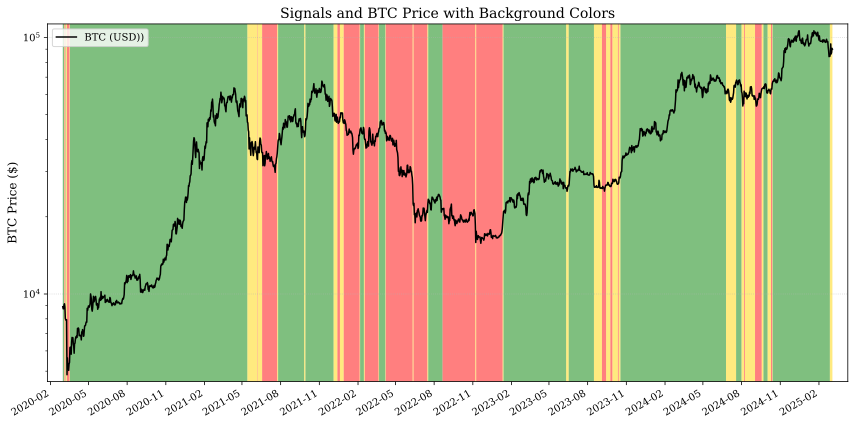

In [497]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import to_rgba
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Create the figure and the primary axes
fig, ax = plt.subplots(figsize=(12, 6))

# --- Add Background Colors ---
signal_colors = {
    'green': to_rgba('green', 1),
    'yellow': to_rgba('gold', 1),
    'red': to_rgba('red', 1),
    'None': to_rgba('white', 1) # Transparent for "None"
}

# Find where the signal changes
signal_changes = data['signal'] != data['signal'].shift(1)
change_indices = data.index[signal_changes].tolist()
# Ensure the first and last dates are included to cover the whole range
if data.index[0] not in change_indices:
    change_indices.insert(0, data.index[0])
if data.index[-1] not in change_indices:
    change_indices.append(data.index[-1])

# Add colored vertical spans (backgrounds)
for i in range(len(change_indices) - 1):
    start_date = change_indices[i]
    end_date = change_indices[i+1]
    # Get the signal value for this period (use the start date's signal)
    signal_value = data.loc[start_date, 'signal']
    # Get the color for this signal
    color = signal_colors.get(signal_value, 'white') # Default to white if signal not found
    
    # Add the vertical span using axvspan
    ax.axvspan(start_date, end_date, facecolor=color, alpha=0.5, zorder=0) 

# Set the label and limits for the left y-axis
ax.set_ylabel('USD', color='black', fontsize=12)
ax.tick_params(axis='y', labelcolor='black')

# Plot the 'BTCUSD' column on the left axis
ax.plot(data.index, data['BTCUSD'], color='black', label='BTC (USD))', linewidth=1.5) # Ensure price is above background

# Set the label for the right y-axis and use log scale
ax.set_ylabel('BTC Price ($)', color='black', fontsize=12)
ax.set_yscale('log') # Use logarithmic scale for price
ax.tick_params(axis='y', labelcolor='black')

# --- Formatting ---

# Improve date formatting on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Ticks every 6 months
fig.autofmt_xdate() # Auto-rotate date labels

# Add a title
plt.title('Signals and BTC Price with Background Colors', fontsize=14)

# ax.legend(lines + lines2, labels + labels2, loc='upper left') # Use this if signal lines are plotted
ax.legend(loc='upper left') # Use this if only BTC line is plotted

# Add grid lines for better readability (optional)
# ax.grid(True, axis='y', linestyle='--', alpha=0.6) # Grid for left axis
ax.grid(True, axis='y', linestyle=':', alpha=0.6) # Grid for right axis (price)
ax.margins(0.02, 0.02)
# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [498]:
details["taxed"]["stats"]["Total Trades"] = 14; details["taxed"]["stats"]["Total Closed Trades"] = 14
fullstats = pd.concat([bh_pf.stats(), less_ords.stats(), cpf_fo.stats(), details["taxed"]["stats"]], axis=1)
fullstats.columns = ['Buy & Hold (benchmark)',  'Long green, sell yellow/red', "Signal dep. sizing", 'Long green, sell yellow/red (with_tax)']
fullstats

,Buy & Hold (benchmark),"Long green, sell yellow/red",Signal dep. sizing,"Long green, sell yellow/red (with_tax)"
Start,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
End,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00
Period,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00
Start Value,10000.0,10000.0,10000.0,10000.0
End Value,100890.676637,187885.786626,123337.683456,108865.14985
Total Return [%],908.906766,1778.857866,1133.376835,988.651499
Benchmark Return [%],908.906766,908.906766,908.906766,988.651499
Max Gross Exposure [%],100.0,100.0,100.0,100.0
Total Fees Paid,0.0,0.0,0.0,0.0
Max Drawdown [%],76.670182,40.37905,56.71749,50.922891
